In [1]:
import numpy as np
from femo.data.pipeline import Pipeline
import pywt
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from scipy.signal import decimate
from scipy.interpolate import interp1d
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [2]:
pipe = Pipeline('/home/leon/FeMo_Analysis/configs/dataset-cfg.yaml')

In [3]:
output = pipe.process('/home/leon/FeMo_Analysis/data/F4_12_FA_8D_08_04-log_2024_06_14_12_24_32.dat', ['fm_dict', 'sensation_map', 'extracted_detections'])
print(output.keys())

/home/leon/FeMo_Analysis/femo/data/transforms/load.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.64493935 1.62404211 1.63839322 ... 1.79096818 1.72555734 1.58426184]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  selected_sensor_data.loc[:, column] = (selected_sensor_data[column] / max_sensor_value) * max_voltage
/home/leon/FeMo_Analysis/femo/data/transforms/load.py:79: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.4766537  1.47766079 1.48239414 ... 1.96766308 2.60354314 3.3       ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  selected_sensor_data.loc[:, column] = (selected_sensor_data[column] / max_sensor_value) * max_voltage
/home/leon/FeMo_Analysis/femo/data/transforms/load.py:79: FutureWarning: Setting an item of incompatible dtype is deprec

dict_keys(['loaded_data', 'preprocessed_data', 'imu_map', 'fm_dict', 'scheme_dict', 'sensation_map', 'extracted_detections', 'extracted_features'])


In [4]:
print(output['extracted_detections'].keys())

dict_keys(['tp_detections_indices', 'tp_detections_sensor_data', 'tp_detections_imu_acceleration', 'tp_detections_imu_rotation', 'fp_detections_indices', 'fp_detections_sensor_data', 'fp_detections_imu_acceleration', 'fp_detections_imu_rotation'])


In [5]:
nonfm_events = output['extracted_detections']['fp_detections_sensor_data']
fm_events = output['extracted_detections']['tp_detections_sensor_data']

print(f"{len(fm_events) = }")
print(f"{len(nonfm_events) = }")

len(fm_events) = 35
len(nonfm_events) = 67


In [6]:
fm_lengths = []
for event in fm_events:
    fm_lengths.append(len(event))

nonfm_lengths = []
for event in nonfm_events:
    nonfm_lengths.append(len(event))

In [7]:
def resample_signal(signal, target_len, freq=1024):

    resampling_factor = target_len / len(signal)
    resampled_freq = freq * resampling_factor

    original_len = len(signal)
    duration = len(signal) / freq
    # Define the time points for the original and target signals
    original_time = np.linspace(0, duration, original_len)  # Original time points
    target_time = np.linspace(0, duration, target_len)      # Target time points for resampling

    # Perform cubic spline interpolation
    interpolator = interp1d(original_time, signal, kind='cubic')
    resampled_signal = interpolator(target_time)

    return resampled_signal, int(resampled_freq)

# Assuming signal is your array with n_samples sampled at 1024 Hz
def downsample_signal(signal, original_freq=1024, target_freq=256):
    # Calculate the downsampling factor
    downsample_factor = original_freq // target_freq
    # Downsample the signal with an anti-aliasing filter
    downsampled_signal = decimate(signal, downsample_factor, ftype='iir')
    return downsampled_signal

In [8]:
def plot_signals(signals, freqs: list[int], labels: list[str]=None, title="Signal Time-Series Data"):
    """
    Plots a list of time-series signals.
    
    Parameters:
    - signals (list of lists or numpy arrays): List of signal vectors with variable lengths.
    - title (str): The title of the entire plot.
    """
    num_signals = len(signals)
    fig, axs = plt.subplots(num_signals, 1, figsize=(10, 2 * num_signals), sharex=True)
    fig.suptitle(title, fontsize=16)
    
    # Ensure axs is always iterable (wrap it in a list if there's only one subplot)
    if num_signals == 1:
        axs = [axs]
    
    for i, signal in enumerate(signals):
        time_data = np.arange(0, len(signal), 1)
        time_data = time_data / freqs[i]
        ax = axs[i]
        label = labels[i] if labels is not None else f"Signal {i+1}"
        ax.plot(time_data, signal, label=label)
        ax.set_ylabel("Amplitude")
        ax.legend(loc="upper right")
    
    # Set x-axis label on the last subplot
    axs[-1].set_xlabel("Time (Samples)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
    plt.show()

In [9]:
def plot_signals_interactive(signals, freqs, labels=None, title="Signal Time-Series Data"):
    """
    Plots a list of time-series signals interactively using Plotly.
    
    Parameters:
    - signals (list of lists or numpy arrays): List of signal vectors with variable lengths.
    - freqs (list of ints): List of sampling frequencies for each signal.
    - labels (list of str, optional): List of labels for each signal.
    - title (str): The title of the entire plot.
    """
    num_signals = len(signals)
    labels = labels if labels is not None else [f"Signal {i+1}" for i in range(num_signals)]
    
    # Create a subplot figure with one row per signal
    fig = make_subplots(rows=num_signals, cols=1, shared_xaxes=True, vertical_spacing=0.05)
    
    for i, signal in enumerate(signals):
        # Create time data based on sampling frequency
        time_data = np.arange(0, len(signal)) / freqs[i]
        
        # Create the trace for the current signal
        trace = go.Scatter(
            x=time_data,
            y=signal,
            mode='lines',
            name=labels[i]
        )
        
        # Add the trace to the corresponding subplot row
        fig.add_trace(trace, row=i+1, col=1)
        
        # Set Y-axis label
        fig.update_yaxes(title_text="Amplitude", row=i+1, col=1)
    
    # Set the title and shared x-axis label
    fig.update_layout(
        title_text=title,
        height=200 * num_signals,
        showlegend=True,
        xaxis_title="Time (Seconds)"
    )
    
    fig.show()

# Example usage
# signals = [np.sin(2 * np.pi * 0.5 * np.linspace(0, 10, 1024)), np.random.randn(512)]
# freqs = [1024, 256]
# plot_signals_interactive(signals, freqs)


In [10]:
def plot_coefficients(coefficients_list, labels=None, title="Wavelet Coefficients", figsize=(8, 2)):
    """
    Plots a list of wavelet coefficient matrices in a single stacked plot with additional space for the title.
    
    Parameters:
    - coefficients_list (list of 2D arrays): List of wavelet coefficient matrices to plot.
    - labels (list of str, optional): Labels for each coefficient matrix plot.
    - title (str): Title of the entire plot.
    - figsize (tuple): Base figure size; total figure height scales with the number of matrices.
    """
    num_plots = len(coefficients_list)
    labels = labels if labels is not None else [f"Coefficients {i+1}" for i in range(num_plots)]
    
    # Set up the figure size to give each matrix its own vertical space
    fig = plt.figure(figsize=(figsize[0], figsize[1] * num_plots))
    
    # Add a larger margin above the title to avoid overlap
    fig.suptitle(title, fontsize=16, y=1.02)
    
    for i, coefficients in enumerate(coefficients_list):
        ax = fig.add_subplot(num_plots, 1, i + 1)
        cax = ax.matshow(coefficients, aspect='auto', cmap='viridis')
        
        # Set label and color bar for each plot
        ax.set_ylabel("Scale")
        ax.set_title(labels[i])
        fig.colorbar(cax, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
    
    # Set x-axis label on the last matrix
    ax.set_xlabel("Samples")
    
    # Add padding between subplots and around the figure borders, with more space at the top for the title
    fig.subplots_adjust(top=0.88, bottom=0.1, left=0.1, right=0.9, hspace=0.5)
    
    plt.show()

# Example usage
# coefficients1, _ = pywt.cwt(signal1, scales=np.arange(1, 33), wavelet='mexh')
# coefficients2, _ = pywt.cwt(signal2, scales=np.arange(1, 33), wavelet='mexh')
# plot_coefficients([coefficients1, coefficients2], labels=["Signal 1", "Signal 2"])


In [11]:
sample = np.random.randint(0, len(fm_events))
sensor = 0  # 0: acclm_1, 1: acclm_2, 2: piezo_l1, 3: piezo_s1, 4: piezo_s2, 5: piezo_l2
print(sample)

30


In [12]:
orig_freq = 1024
down_freq = 256
target_len = 512

In [13]:
orig_signal = fm_events[sample][:, sensor]
print(f"{orig_signal.shape = }")

downsampled_signal = downsample_signal(orig_signal, orig_freq, down_freq)
print(f"{downsampled_signal.shape = }")

resampled_signal, resampled_freq = resample_signal(downsampled_signal, target_len, down_freq)
print(f"{resampled_signal.shape = }")
print(f"{resampled_freq = }")

plot_signals_interactive([orig_signal, downsampled_signal, resampled_signal], freqs=[orig_freq, down_freq, resampled_freq],
             labels=[f'original ({orig_freq}Hz)', f'downsampled ({down_freq}Hz)', f'resampled ({resampled_freq}Hz)'])

orig_signal.shape = (9400,)
downsampled_signal.shape = (2350,)
resampled_signal.shape = (512,)
resampled_freq = 55


(32, 9400)
(32, 2350)
(16, 512)


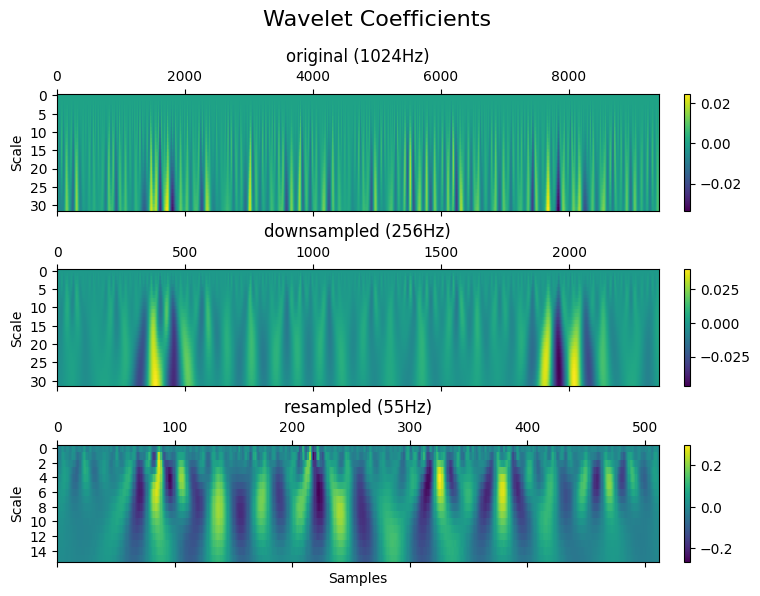

In [28]:
original_coefficients, _ = pywt.cwt(orig_signal, scales=np.arange(1, 33), wavelet='mexh')
downsampled_coefficients, _ = pywt.cwt(downsampled_signal, scales=np.arange(1, 33), wavelet='mexh')
resampled_coefficients, _ = pywt.cwt(resampled_signal, scales=np.arange(1, 17), wavelet='mexh')
# resampled_coefficients = zoom(resampled_coefficients, 0.25, order=0)

print(f"{original_coefficients.shape}")
print(f"{downsampled_coefficients.shape}")
print(f"{resampled_coefficients.shape}")

plot_coefficients([original_coefficients, downsampled_coefficients, resampled_coefficients],
                  labels=[f'original ({orig_freq}Hz)', f'downsampled ({down_freq}Hz)', f'resampled ({resampled_freq}Hz)'])

In [25]:
channels = []
for sensor in range(fm_events[sample].shape[1]):
    signal = fm_events[sample][:, sensor]
    resampled_signal, resampled_freq = resample_signal(downsample_signal(signal, orig_freq, down_freq), target_len, down_freq)

    coeffs, _ = pywt.cwt(resampled_signal, scales=np.arange(1, 17), wavelet='mexh')
    coeffs = zoom(coeffs, 0.25, order=0)
    channels.append(np.swapaxes(coeffs, 0, 1))

fm_example = np.swapaxes(channels, 0, 1)
print(f"{fm_example.shape = }")

fm_example.shape = (128, 6, 4)


`fm_example.shape = (512, 6, 16)`
(#timesteps, #sensors, #scales)

This is the shape of an input data to GNN model. So now need to create the model.\
Ref. [Self-attention-based-GNN-for-sEMG](https://github.com/steve30572/Self-attention-based-GNN-for-sEMG/tree/master)

In [17]:
print(len(1 + np.zeros(fm_example.shape[0])))

512


In [37]:
example_labels = np.load("/home/leon/Self-attention-based-GNN-for-sEMG/data/list_labels.npy", allow_pickle=True, encoding="bytes")
print(example_labels.shape)

(1, 2)


In [38]:
example_dataset = np.load("/home/leon/Self-attention-based-GNN-for-sEMG/data/list_dataset.npy", allow_pickle=True, encoding="bytes")
print(example_dataset.shape)

(1, 2)


In [41]:
for i in range(example_dataset.shape[1]):
    print(example_dataset[0][i].shape)
    print(example_labels[0][i])

(67, 512, 6, 16)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(35, 512, 6, 16)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
